<a href="https://colab.research.google.com/github/ordavidov/ocl_lab/blob/aaai/aaai/profile.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

*****

We begin by installing the Python package [`doframework`](https://github.com/IBM/doframework). If you are getting errors, restart the runtime and run this cell again (the errors are due to mismatches between Google Colab built-in environment packages and `doframework` requirements that cannot be automatically resolved).

In [ ]:
%pip install doframework

In [2]:
import os
import yaml
import json

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

from doframework.core.storage import Storage
from doframework.core.inputs import get_configs
from doframework.core.gp import find_modal
from doframework.flow.metrics import files_from_solution

In [3]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/MyDrive/ocl_lab/notebooks/DOFramework

Mounted at /content/drive
/content/drive/MyDrive/ocl_lab/notebooks/DOFramework


# DOFramework Profiling

*****

This notebook demonstrates the use of `doframework` to establish the profile of DO model learner. 

`doframework` randomly generates _optimization problem instances_ $(f,\Omega,D,\mathbf{x}^*)$ consisting of 
* $f: \mathbb{R}^d → \mathbb{R}$ a continuous piece-wise linear objective.
* $\Omega ⊆ \mathbb{R}^d$ a feasibility region as a bounded convex $d$-polytope.
* $D = (X,y)$ data associated with $f$ so that $X ⊆ \mbox{dom}(f)$ and $y = f(\mathbf{x}) + ϵ$, $ϵ \sim \mathcal{N}(0,σ^2)$.
* $\mathbf{x}^* = \arg \min_{\mathbf{x} \in Ω} f(\mathbf{x})$ the ground-truth optimum.

`doframework` feeds $(\Omega,D)$ into the user's DO model learner and collects its predicted optimum $\hat{\mathbf{x}}$. It establishes its profile by comparing $f(\hat{\mathbf{x}})$ to $f(\mathbf{x})$ across all optimization problem instances.

We will run this notebook against simulation products we previsouly generated by running `doframework` against [OptiCL](https://github.com/hwiberg/OptiCL) with Trust Region. `doframework` randomly generated 650 tuples $(f,\Omega,D,\mathbf{x}^*)$ in dimensions 5 and 7.

# Configs

`doframework` relies on a configs yaml to enable its interaction with storage. Storage can be S3 buckets (AWS / IBM Cloud) or a local file system. Here, we will rely on local storage. We already uploaded `opticl_configs.yaml` to our `ocl_lab/notebooks/DOFramework` directory. 

In [4]:
configs_root = os.getcwd()
configs_file = 'opticl_configs.yaml'
configs_path = os.path.join(configs_root,configs_file)

configs = get_configs(configs_path)

# Storage

We will fetch all solution files following a `doframework` experiment.

In [5]:
storage = Storage(configs)

In [6]:
buckets = storage.buckets()

We can limit the number of files to fetch with `limit=`.

In [7]:
solution_files = storage.get_all(buckets['solutions'],'json',limit=650)

# Problem Type

We choose which problems to analyze: either minimum or maximum.

In [8]:
opt = 'min'

# Fetch Results

Fetching all results may take time, depending on your machine or network.

In [9]:
rel_perfs = []

for file in solution_files:
    
    solution_name = file.key if 's3' in configs else file.name
    
    solution_obj = storage.get(buckets['solutions'],solution_name)
    solution = json.load(solution_obj)
            
    assoc_files = files_from_solution(solution_name)
    objective_name = assoc_files['objective']
    data_name = assoc_files['data']
    
    # get relevant objective
    objective_obj = storage.get(buckets['objectives_dest'],objective_name)
    objective = json.load(objective_obj)    
    dim = len(objective['optimum'][opt]['arg'])
            
    if solution['solution'][opt] != 'FAILED':
        
        solution_val = solution['solution'][opt]['value']
        true_min_val = objective['optimum']['min']['value']
        true_max_val = objective['optimum']['max']['value']

        rel_perf = (solution_val-true_min_val)/(true_max_val-true_min_val)
        rel_perfs.append([solution_name,objective_name,data_name,dim,rel_perf,True])
        
    else:
        
        rel_perfs.append([solution_name,objective_name,data_name,dim,np.nan,False])        
            

In [10]:
df = pd.DataFrame(rel_perfs,columns=['solution','objective','data','dimension','score','success'])

In [11]:
solution_num = df.shape[0]
solution_good = df[~df.score.isna()].shape[0]

print('Reviewed {} solutions.'.format(solution_num))
print('Of those, {:.2f}% succsessful.'.format(100*(solution_good/solution_num)))

Reviewed 650 solutions.
Of those, 94.46% succsessful.


# Profile

Each optimization problem instance $(f,\Omega,D,\mathbf{x}^*)$ has a predicted optimum $\hat{\mathbf{x}}$ produced by the DO model learner. The score of that predicted optimum relative to the true optimum is

$$\text{score}(\hat{\mathbf{x}}) = \frac{f(\hat{\mathbf{x}})-f(\mathbf{x}_\min)}{f_\max-f_\min}$$

Let's see how the scores are distributed across all generated optimization problem instances.

In [12]:
df[['solution','dimension','score','success']].head()

,solution,dimension,score,success
0,solution_051fwi62_9qm4j08f_9cbl4btp.json,7,0.452920,True
1,solution_03h5bdk9_bsm1g70l_g3d4bbjq.json,7,0.199511,True
2,solution_00n7ij1v_1cvhizdl_vi305l04.json,5,0.569573,True
3,solution_03h5bdk9_4ntc4wxh_5y44wmcm.json,7,0.282968,True
4,solution_051fwi62_dnini68g_nclq7vdo.json,7,0.483857,True


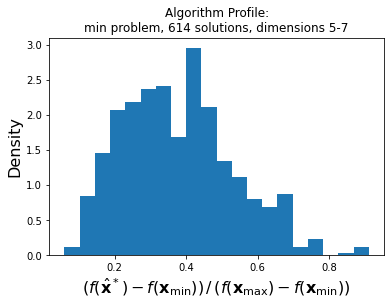

In [13]:
plt.hist(df.score,density=True,bins=20)
plt.title('Algorithm Profile:\n{} problem, {} solutions, dimensions {}-{}'.\
          format(opt,solution_good,min(df.dimension),max(df.dimension)))
plt.xlabel(r'$(f(\hat{\mathbf{x}}^*)-f(\mathbf{x}_\min))\,/\,(f(\mathbf{x}_\max)-f(\mathbf{x}_\min))$',fontsize=16)
plt.ylabel(r'Density',fontsize=16)
plt.show()

In [14]:
print('Mean Score: {:.2f}'.format(df.score.mean()))
print('Median Score: {:.2f}'.format(df.score.median()))
print('Score Distribution Mode: {:.2f}'.format(find_modal(df[~df.score.isna()].score)[0]))

Mean Score: 0.38
Median Score: 0.36
Score Distribution Mode: 0.41


# Probability

Using the empirical score density, we can estimate the probability 

$$Pr[f(\hat{\mathbf{x}}) - f(\mathbf{x}_{\min}) <  \epsilon \cdot (f_{\max}-f_{\min})]$$

of the DO model learner to hit the true optimum. 

In [15]:
kde = gaussian_kde(df[~df.score.isna()].score)

epsilon = 0.4

print('Empirical probability (epsilon={:.2f}): {:.2f}'.format(epsilon,kde.integrate_box_1d(0,epsilon)))

Empirical probability (epsilon=0.40): 0.58
